In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bb-mas-dataset/user1/1_HandPhone_Gyroscope_(Samsung_S6).csv
/kaggle/input/bb-mas-dataset/user1/1_HandPhone_Accelerometer_(Samsung_S6).csv
/kaggle/input/bb-mas-dataset/user2/2_HandPhone_Accelerometer_(Samsung_S6).csv
/kaggle/input/bb-mas-dataset/user2/2_HandPhone_Gyroscope_(Samsung_S6).csv


In [32]:
!pip install torchinfo pandas scikit-learn matplotlib seaborn

In [33]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader


In [34]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math

In [35]:
import pandas as pd

# File paths
acc_user1_path = "/kaggle/input/bb-mas-dataset/user1/1_HandPhone_Accelerometer_(Samsung_S6).csv"
gyro_user1_path = "/kaggle/input/bb-mas-dataset/user1/1_HandPhone_Gyroscope_(Samsung_S6).csv"

acc_user2_path = "/kaggle/input/bb-mas-dataset/user2/2_HandPhone_Accelerometer_(Samsung_S6).csv"
gyro_user2_path = "/kaggle/input/bb-mas-dataset/user2/2_HandPhone_Gyroscope_(Samsung_S6).csv"

# Load into DataFrames
acc_user1 = pd.read_csv(acc_user1_path)
gyro_user1 = pd.read_csv(gyro_user1_path)

acc_user2 = pd.read_csv(acc_user2_path)
gyro_user2 = pd.read_csv(gyro_user2_path)

# Convert time columns to datetime
acc_user1['time'] = pd.to_datetime(acc_user1['time'])
gyro_user1['time'] = pd.to_datetime(gyro_user1['time'])

acc_user2['time'] = pd.to_datetime(acc_user2['time'])
gyro_user2['time'] = pd.to_datetime(gyro_user2['time'])

# Print summary
print(" User1 Accelerometer:\n", acc_user1.head(), "\n")
print(" User1 Gyroscope:\n", gyro_user1.head(), "\n")
print(" User2 Accelerometer:\n", acc_user2.head(), "\n")
print(" User2 Gyroscope:\n", gyro_user2.head(), "\n")


 User1 Accelerometer:
    EID    Xvalue    Yvalue    Zvalue                    time
0    0  1.043872  3.245340  9.087193 2017-04-14 18:56:40.215
1    1  0.995988  3.303998  8.936357 2017-04-14 18:56:40.216
2    2  0.988805  3.355474  8.880095 2017-04-14 18:56:40.234
3    3  1.031901  3.456030  8.804677 2017-04-14 18:56:40.234
4    4  1.162385  3.575740  8.757990 2017-04-14 18:56:40.269 

 User1 Gyroscope:
    EID    Xvalue    Yvalue    Zvalue                    time
0    0 -0.045806  0.036219 -0.013848 2017-04-14 18:56:40.440
1    1 -0.027697  0.027697 -0.017044 2017-04-14 18:56:40.449
2    2 -0.013848  0.022371 -0.017044 2017-04-14 18:56:40.461
3    3 -0.009587  0.020240 -0.013848 2017-04-14 18:56:40.469
4    4 -0.007457  0.026632 -0.014914 2017-04-14 18:56:40.480 

 User2 Accelerometer:
    EID    Xvalue    Yvalue    Zvalue                    time
0    0  1.136049  5.620389  6.811504 2017-04-17 14:19:18.005
1    1  1.511938  5.567716  6.630742 2017-04-17 14:19:18.006
2    2  1.690306

In [36]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load CSVs
user1_acc = pd.read_csv("/kaggle/input/bb-mas-dataset/user1/1_HandPhone_Accelerometer_(Samsung_S6).csv")
user1_gyr = pd.read_csv("/kaggle/input/bb-mas-dataset/user1/1_HandPhone_Gyroscope_(Samsung_S6).csv")
user2_acc = pd.read_csv("/kaggle/input/bb-mas-dataset/user2/2_HandPhone_Accelerometer_(Samsung_S6).csv")
user2_gyr = pd.read_csv("/kaggle/input/bb-mas-dataset/user2/2_HandPhone_Gyroscope_(Samsung_S6).csv")

# Parse time
for df in [user1_acc, user1_gyr, user2_acc, user2_gyr]:
    df['time'] = pd.to_datetime(df['time'])

# Rename columns
def rename_cols(df, prefix):
    return df.rename(columns={
        'Xvalue': f'Xvalue_{prefix}',
        'Yvalue': f'Yvalue_{prefix}',
        'Zvalue': f'Zvalue_{prefix}'
    }).drop(columns=['EID'])

user1_acc = rename_cols(user1_acc, 'acc')
user1_gyr = rename_cols(user1_gyr, 'gyro')
user2_acc = rename_cols(user2_acc, 'acc')
user2_gyr = rename_cols(user2_gyr, 'gyro')

# Merge accel + gyro on time
def merge_and_label(acc_df, gyr_df, user_label):
    df = pd.merge_asof(
        acc_df.sort_values('time'), 
        gyr_df.sort_values('time'), 
        on='time',
        direction='nearest',
        tolerance=pd.Timedelta(milliseconds=20)  # Optional: only merge if within 20ms
    )
    df = df.dropna().reset_index(drop=True)
    df['User'] = user_label
    return df

user1 = merge_and_label(user1_acc, user1_gyr, "User1")
user2 = merge_and_label(user2_acc, user2_gyr, "User2")

# Combine both users
final_df = pd.concat([user1, user2], ignore_index=True)

# Encode users
label_encoder = LabelEncoder()
final_df["UserEncoded"] = label_encoder.fit_transform(final_df["User"])

# ✅ Summary
print("✅ Final merged DataFrame shape:", final_df.shape)
print("User distribution:\n", final_df['User'].value_counts())
print("\nSample data:\n", final_df.head())


✅ Final merged DataFrame shape: (469137, 9)
User distribution:
 User
User1    295004
User2    174133
Name: count, dtype: int64

Sample data:
    Xvalue_acc  Yvalue_acc  Zvalue_acc                    time  Xvalue_gyro  \
0    1.064223    3.495534    9.041702 2017-04-14 18:56:40.420    -0.045806   
1    1.007959    3.491943    9.198523 2017-04-14 18:56:40.429    -0.045806   
2    1.041478    3.521871    9.161413 2017-04-14 18:56:40.440    -0.045806   
3    1.041478    3.495534    9.163807 2017-04-14 18:56:40.449    -0.027697   
4    0.919373    3.397372    9.099164 2017-04-14 18:56:40.461    -0.013848   

   Yvalue_gyro  Zvalue_gyro   User  UserEncoded  
0     0.036219    -0.013848  User1            0  
1     0.036219    -0.013848  User1            0  
2     0.036219    -0.013848  User1            0  
3     0.027697    -0.017044  User1            0  
4     0.022371    -0.017044  User1            0  


In [37]:
final_df

,Xvalue_acc,Yvalue_acc,Zvalue_acc,time,Xvalue_gyro,Yvalue_gyro,Zvalue_gyro,User,UserEncoded
0,1.064223,3.495534,9.041702,2017-04-14 18:56:40.420,-0.045806,0.036219,-0.013848,User1,0
1,1.007959,3.491943,9.198523,2017-04-14 18:56:40.429,-0.045806,0.036219,-0.013848,User1,0
2,1.041478,3.521871,9.161413,2017-04-14 18:56:40.440,-0.045806,0.036219,-0.013848,User1,0
3,1.041478,3.495534,9.163807,2017-04-14 18:56:40.449,-0.027697,0.027697,-0.017044,User1,0
4,0.919373,3.397372,9.099164,2017-04-14 18:56:40.461,-0.013848,0.022371,-0.017044,User1,0
...,...,...,...,...,...,...,...,...,...
469132,-1.529895,0.749385,9.597157,2017-04-17 14:47:43.503,0.042611,-0.049002,0.063916,User2,1
469133,-1.467646,0.821211,9.113529,2017-04-17 14:47:43.503,0.042611,-0.049002,0.063916,User2,1
469134,-1.529895,0.737414,9.731233,2017-04-17 14:47:43.534,0.139550,-0.067112,0.087352,User2,1
469135,-1.624466,0.778116,9.394848,2017-04-17 14:47:43.534,0.139550,-0.067112,0.087352,User2,1


In [39]:
print(df.columns)


Index(['EID', 'Xvalue', 'Yvalue', 'Zvalue', 'time'], dtype='object')


In [40]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

SEQ_LEN = 50  # Window size
X, y = [], []

# ✅ Sort by time to maintain sequence order
final_df = final_df.sort_values(by='time').reset_index(drop=True)

# ✅ Define motion features to use
motion_features = [
    'Xvalue_acc', 'Yvalue_acc', 'Zvalue_acc',
    'Xvalue_gyro', 'Yvalue_gyro', 'Zvalue_gyro'
]

# ✅ Normalize features (recommended)
scaler = StandardScaler()
final_df[motion_features] = scaler.fit_transform(final_df[motion_features])

# ✅ Build sequences
for i in tqdm(range(len(final_df) - SEQ_LEN)):
    segment = final_df.iloc[i:i + SEQ_LEN]
    users = segment['UserEncoded']

    if len(set(users)) == 1:  # Ensure the segment is from a single user
        X.append(segment[motion_features].values)  # Shape: [SEQ_LEN, 6]
        y.append(users.iloc[0])                   # Class label

# ✅ Convert to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)  # Shape: [N, 50, 6]
y_tensor = torch.tensor(y, dtype=torch.long)     # Shape: [N]

print(f"✅ Final Tensor Shapes: X = {X_tensor.shape}, y = {y_tensor.shape}")


100%|██████████| 469087/469087 [04:12<00:00, 1860.72it/s]


✅ Final Tensor Shapes: X = torch.Size([469038, 50, 6]), y = torch.Size([469038])


/tmp/ipykernel_36/3934470010.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  X_tensor = torch.tensor(X, dtype=torch.float32)  # Shape: [N, 50, 6]


In [41]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)


✅ Using device: cuda


In [42]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Convert tensors to NumPy arrays for stratified split
X_np = X_tensor.numpy()
y_np = y_tensor.numpy()

# ✅ Stratified split to maintain class balance
X_train, X_val, y_train, y_val = train_test_split(
    X_np, y_np, test_size=0.2, stratify=y_np, random_state=42
)

# ✅ Convert back to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val   = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val   = torch.tensor(y_val, dtype=torch.long)

# ✅ Create datasets and dataloaders
train_ds = TensorDataset(X_train, y_train)
val_ds   = TensorDataset(X_val, y_val)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=32)

# ✅ Compute class weights for imbalanced data
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_np),
    y=y_np
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("✅ Class Weights:", class_weights)


✅ Class Weights: tensor([0.7951, 1.3472], device='cuda:0')


In [43]:
import torch
import torch.nn as nn
import math

# ---------------- Positional Encoding ---------------- #
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # [1, max_len, d_model]

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# ---------------- Multi-Head Attention ---------------- #
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads

        self.q = nn.Linear(d_model, d_model)
        self.k = nn.Linear(d_model, d_model)
        self.v = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, T, D = x.shape
        H = self.num_heads
        d_k = self.d_k

        Q = self.q(x).view(B, T, H, d_k).transpose(1, 2)
        K = self.k(x).view(B, T, H, d_k).transpose(1, 2)
        V = self.v(x).view(B, T, H, d_k).transpose(1, 2)

        scores = Q @ K.transpose(-2, -1) / math.sqrt(d_k)
        weights = torch.softmax(scores, dim=-1)
        output = weights @ V
        output = output.transpose(1, 2).contiguous().view(B, T, D)
        return self.out(output)

# ---------------- Transformer Block ---------------- #
class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim=128, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)

        self.ff = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        x = self.norm1(x + self.dropout1(self.attn(x)))
        x = self.norm2(x + self.dropout2(self.ff(x)))
        return x

# ---------------- Final Gait Model ---------------- #
class GaitTransformerBiLSTMClassifier(nn.Module):
    def __init__(self, input_dim=6, d_model=64, num_heads=8, num_layers=3,
                 num_classes=2, ff_dim=128, dropout=0.1, lstm_hidden=128):
        super().__init__()
        # Linear projection for real-valued features
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model)

        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(d_model, num_heads, ff_dim, dropout) for _ in range(num_layers)]
        )

        self.bilstm = nn.LSTM(input_size=d_model, hidden_size=lstm_hidden,
                              num_layers=1, batch_first=True, bidirectional=True)

        self.classifier = nn.Sequential(
            nn.Linear(2 * lstm_hidden, lstm_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_hidden, num_classes)
        )

    def forward(self, x):  # x: [batch_size, seq_len, input_dim]
        x = self.input_proj(x)           # [B, T, d_model]
        x = self.pos_enc(x)              # Positional encoding
        x = self.transformer_blocks(x)   # Transformer
        lstm_out, _ = self.bilstm(x)     # [B, T, 2*lstm_hidden]
        x = lstm_out.mean(dim=1)         # Global mean pooling
        return self.classifier(x)        # Output logits


In [44]:
input_dim = 6  # [X_acc, Y_acc, Z_acc, X_gyro, Y_gyro, Z_gyro]
model = GaitTransformerBiLSTMClassifier(input_dim=input_dim).to(device)

# Loss and optimizer
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [45]:
def train(model, train_dl, val_dl, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        batch_count = 0

        for xb, yb in tqdm(train_dl, desc=f"Epoch {epoch+1}/{epochs}"):
            xb = xb.float().to(device)  # ✅ Use float32 for gait data
            yb = yb.to(device)

            preds = model(xb)
            loss = loss_fn(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            batch_count += 1

        avg_loss = total_loss / batch_count

        # === Validation ===
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for xb, yb in val_dl:
                xb = xb.float().to(device)  # ✅ Also use float here
                yb = yb.to(device)

                preds = model(xb)
                correct += (preds.argmax(1) == yb).sum().item()
                total += yb.size(0)

        acc = correct / total
        print(f"✅ Epoch {epoch+1} | Avg Loss: {avg_loss:.4f} | Val Acc: {acc:.2%}")


In [46]:
train(model, train_dl, val_dl, epochs=10)

Epoch 1/10: 100%|██████████| 11726/11726 [01:52<00:00, 103.90it/s]


✅ Epoch 1 | Avg Loss: 0.0267 | Val Acc: 99.71%


Epoch 2/10: 100%|██████████| 11726/11726 [01:52<00:00, 104.67it/s]


✅ Epoch 2 | Avg Loss: 0.0141 | Val Acc: 99.53%


Epoch 3/10: 100%|██████████| 11726/11726 [01:52<00:00, 104.25it/s]


✅ Epoch 3 | Avg Loss: 0.0121 | Val Acc: 99.72%


Epoch 4/10: 100%|██████████| 11726/11726 [01:52<00:00, 104.29it/s]


✅ Epoch 4 | Avg Loss: 0.0124 | Val Acc: 99.65%


Epoch 5/10: 100%|██████████| 11726/11726 [01:51<00:00, 104.83it/s]


✅ Epoch 5 | Avg Loss: 0.0113 | Val Acc: 99.63%


Epoch 6/10: 100%|██████████| 11726/11726 [01:52<00:00, 104.61it/s]


✅ Epoch 6 | Avg Loss: 0.0115 | Val Acc: 99.72%


Epoch 7/10: 100%|██████████| 11726/11726 [01:52<00:00, 104.45it/s]


✅ Epoch 7 | Avg Loss: 0.0116 | Val Acc: 99.63%


Epoch 8/10: 100%|██████████| 11726/11726 [01:52<00:00, 104.17it/s]


✅ Epoch 8 | Avg Loss: 0.0108 | Val Acc: 99.74%


Epoch 9/10: 100%|██████████| 11726/11726 [01:51<00:00, 104.87it/s]


✅ Epoch 9 | Avg Loss: 0.0108 | Val Acc: 99.67%


Epoch 10/10: 100%|██████████| 11726/11726 [01:52<00:00, 104.55it/s]


✅ Epoch 10 | Avg Loss: 0.0101 | Val Acc: 99.78%


📋 Classification Report:
              precision    recall  f1-score   support

       User1       1.00      1.00      1.00     58991
       User2       1.00      1.00      1.00     34817

    accuracy                           1.00     93808
   macro avg       1.00      1.00      1.00     93808
weighted avg       1.00      1.00      1.00     93808



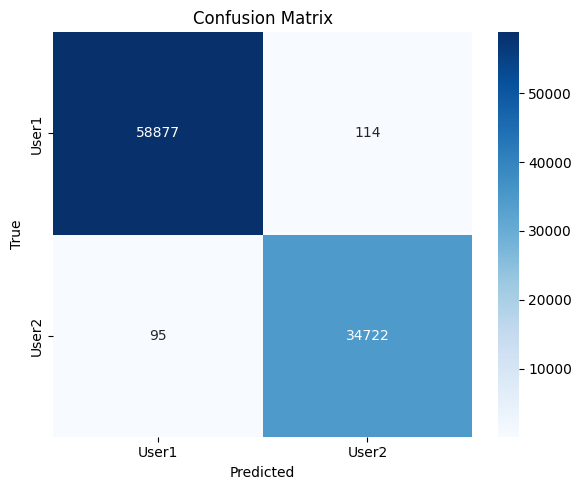

In [50]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure model is in evaluation mode
model.eval()

# Lists to store ground truth and predictions
y_true = []
y_pred = []

# Run inference
with torch.no_grad():
    for xb, yb in val_dl:
        xb = xb.float().to(device)  # Float for gait data
        yb = yb.to(device)
        preds = model(xb)
        y_true.extend(yb.cpu().tolist())
        y_pred.extend(preds.argmax(1).cpu().tolist())

# If user_encoder is not already fitted, fit it now using original dataframe
try:
    target_names = user_encoder.classes_
except:
    user_encoder = LabelEncoder()
    user_encoder.fit(final_df["User"])
    target_names = user_encoder.classes_

# 📋 Classification Report
print("📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# 📊 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


📐 AUC: 1.0000
⚖️ Equal Error Rate (EER): 0.0022 at threshold ≈ 0.4439


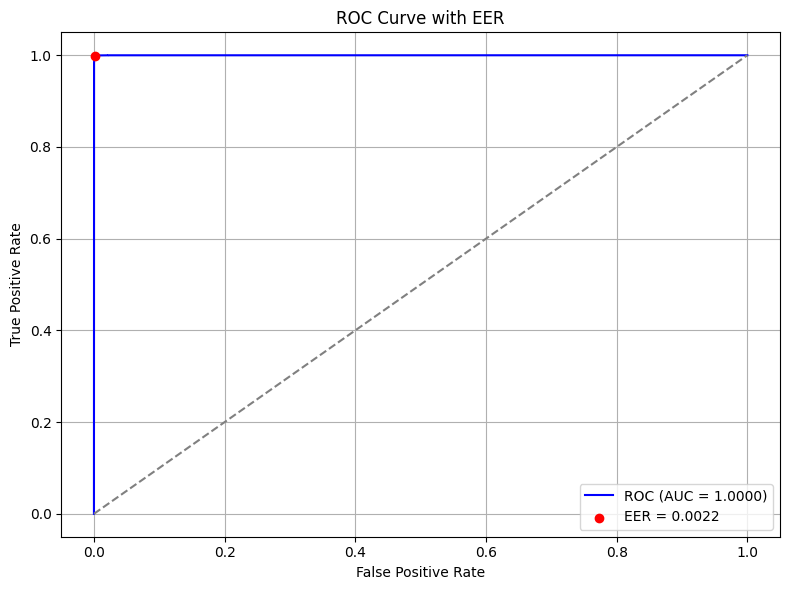

In [52]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

model.eval()
y_probs = []
y_true_bin = []

with torch.no_grad():
    for xb, yb in val_dl:
        xb = xb.float().to(device)  # ✅ Use float for gait features
        yb = yb.to(device)
        probs = torch.softmax(model(xb), dim=1)[:, 1]  # Probability for class 1
        y_probs.extend(probs.cpu().tolist())
        y_true_bin.extend(yb.cpu().tolist())

# Compute ROC and AUC
auc = roc_auc_score(y_true_bin, y_probs)
fpr, tpr, thresholds = roc_curve(y_true_bin, y_probs)

# Compute Equal Error Rate (EER)
fnr = 1 - tpr
eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
eer = fpr[np.nanargmin(np.abs(fnr - fpr))]

print(f"📐 AUC: {auc:.4f}")
print(f"⚖️ Equal Error Rate (EER): {eer:.4f} at threshold ≈ {eer_threshold:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC (AUC = {auc:.4f})', color='blue')
plt.scatter(eer, 1 - eer, color='red', label=f'EER = {eer:.4f}', zorder=10)
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with EER')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [54]:
import random
import torch

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_SAMPLES = 5
SEQ_LEN = 50

# Define motion features
motion_features = [
    'Xvalue_acc', 'Yvalue_acc', 'Zvalue_acc',
    'Xvalue_gyro', 'Yvalue_gyro', 'Zvalue_gyro'
]

print("\n🔍 Predictions on Random 5 Samples Per User\n")

for user_name in user_encoder.classes_:
    user_label = user_encoder.transform([user_name])[0]

    # Filter dataframe for the user
    user_df = final_df[final_df['UserEncoded'] == user_label].reset_index(drop=True)

    print(f"--- User: {user_name} ---")

    for _ in range(NUM_SAMPLES):
        max_start = len(user_df) - SEQ_LEN
        if max_start <= 0:
            print("Not enough data for", user_name)
            break

        start_idx = random.randint(0, max_start)
        segment = user_df.iloc[start_idx:start_idx + SEQ_LEN][motion_features].values

        sample = torch.tensor([segment], dtype=torch.float32).to(device)  # ✅ FloatTensor for gait data

        with torch.no_grad():
            pred = model(sample)
            pred_class = torch.argmax(pred, dim=1).item()

        pred_user = user_encoder.inverse_transform([pred_class])[0]
        print(f"True: {user_name} | Predicted: {pred_user}")
    print()



🔍 Predictions on Random 5 Samples Per User

--- User: User1 ---
True: User1 | Predicted: User1
True: User1 | Predicted: User1
True: User1 | Predicted: User1
True: User1 | Predicted: User1
True: User1 | Predicted: User1

--- User: User2 ---
True: User2 | Predicted: User2
True: User2 | Predicted: User2
True: User2 | Predicted: User2
True: User2 | Predicted: User2
True: User2 | Predicted: User2



In [55]:
# Count total samples
print(f"📦 Total Samples: {len(X)}")

# Count train/val split
print(f"🛠️ Training Samples: {len(X_train)}")
print(f"🧪 Validation Samples: {len(X_val)}")

# Count per user in training and validation
from collections import Counter

train_dist = Counter(y_train.tolist())
val_dist = Counter(y_val.tolist())

print("\n📊 Class Distribution:")
for label in sorted(train_dist.keys()):
    user = user_encoder.inverse_transform([label])[0]
    print(f"  {user} -> Train: {train_dist[label]} | Validation: {val_dist[label]}")

📦 Total Samples: 469038
🛠️ Training Samples: 375230
🧪 Validation Samples: 93808

📊 Class Distribution:
  User1 -> Train: 235964 | Validation: 58991
  User2 -> Train: 139266 | Validation: 34817
